In [1]:
%matplotlib inline
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import statistics as stat

from sklearn.cluster import KMeans

## Copied from aludert's kmeans_datafaker_and_test

### kmeans_datafaker function

In [2]:
def k_means_datafaker(k, centroid_list, dist_chars_list, points_splt, shuffle = 'yes'):
    
    if len(centroid_list) != k:
        print('You ust provide a centroid x,y pair for every cluster')
    if len(dist_chars_list) != k:
        print('You ust provide a covariance matrix for every cluster')
    if len(points_splt) != k:
        print('You ust provide a number of points for every cluster')
        
    total_points = sum(points_splt)    
    points = np.empty([total_points,3])
    
    index = 0
    for i in range(k):

        centroid = centroid_list[i]
        dist_chars = dist_chars_list[i]
        p = points_splt[i]

        points_in_cluster = np.random.multivariate_normal(centroid,dist_chars,p)
        
        points[index:index+p,:2] = points_in_cluster
        points[index:index+p,2] = i+1

        index = index+p
        
    if shuffle == 'yes':
        np.take(points,np.random.permutation(points.shape[0]),axis=0,out=points)

    return points

### kmeans function

In [3]:
def kmeans(points, k,prec=0.000001,m=1, tries = 10, init = 'k-means++'):
    l=len(points)
    
    centroids_matrix = np.empty([tries,k,2])
    list_index_matrix = np.empty([tries,np.shape(points)[0]])
    m_matrix = np.empty([tries])
    DB_matrix = np.empty([tries])
    DB_matrix[:] = np.NaN
    
    if k > l:
        print ('The partitioning is impossible')
    else:
        
        for try_num in range(tries):
            if init == 'empty':
                centroids = np.empty([k,2])

            if init == 'rand_scale':
                #Initialize the centroids as random number times the max x or y coordinate
                centroids = np.random.random([k,2])*np.amax(points)

            if init == 'foggy':
                #initialize centroids as a random selection of k points from the sample 
                #This is called foggy selection
                centroids = np.take(points,np.random.permutation(k),axis=0)

            if init == 'k-means++':
                centroids = np.empty([k,2])
                centroids[:] = np.NaN
                #Choose the first centroid as a random data point
                centroids[0,:] = np.take(points,np.random.randint(np.shape(points)[0]),axis=0)

                for c in range(1,k):
                    #create an array for the distances of every point to the already chosen centroids
                    distances = np.empty([np.shape(points)[0],c])
                    for cc in range(c):
                        distances[:,cc] = np.abs(np.square(points[:,0] - centroids[cc,0]) + np.square(points[:,1] - centroids[cc,1]))
                    distance_min = np.amin(distances, axis=1)
                    distance_probs = distance_min/np.sum(distance_min)
                    new_cluster_index = np.random.choice(np.shape(points)[0],1,p=distance_probs)
                    centroids[c,:] = points[new_cluster_index,:]
             
            # This For loop was making the starting centroids the first k points all the time!
            #for j in range(0, k):
                #centroids[j,:]=points[j,:]
                #print(centroids)
                
            m=1
            while (m > prec):
                new_centroids=np.empty([k,2])
                list_index=[]
                for i in range(0,l):
                    list_dist=[]
                    for j in range(0,k):
                        dist=np.linalg.norm(points[i,:] - centroids[j,:])
                        list_dist.append(dist)
                    min_index=np.argmin(list_dist)
                    list_index.append(min_index)
                for j in range(0,k):
                    indeces=np.where(np.asarray(list_index)==j)[0]
                    if len(indeces) > 0:
                        new_centroids[j,:]=sum(points[indeces])/(len(indeces))
                    else:
                        rand_int=rd.randint(0,l-1)
                        new_centroids[j,:]=points[rand_int,:]
                m=np.linalg.norm(centroids - new_centroids)
                centroids=new_centroids

            list_diameter=[]   
            for j in range(0,k):
                indeces=np.where(np.asarray(list_index)==j)[0]
                diameter=math.sqrt(sum(np.linalg.norm(points[indeces]- centroids[j,:],axis=1)**2)/len(indeces))
                list_diameter.append(diameter)
            Matrix_DB= np.zeros([k,k])
            for i in range(0,k):
                for j in range(0,i-1):
                    Matrix_DB[i,j]=(list_diameter[i]+list_diameter[j])/(np.linalg.norm(centroids[i,:]-centroids[j,:]))
                for j in range(i+1,k):
                    Matrix_DB[i,j]=(list_diameter[i]+list_diameter[j])/(np.linalg.norm(centroids[i,:]-centroids[j,:])) 

            DB=sum(np.amax(Matrix_DB, axis=1))/k
            
            centroids_matrix[try_num,:,:] = centroids[:,:]
            
            list_index_matrix[try_num,:] = list_index[:]
            m_matrix[try_num] = m
            DB_matrix[try_num] = DB
        
    smallest_db_index = np.argmin(DB_matrix)

    out_centroids = centroids_matrix[smallest_db_index,:,:]
    out_list_index = list_index_matrix[smallest_db_index,:]
    out_m = m_matrix[smallest_db_index]
    out_DB = DB_matrix[smallest_db_index]
    
    return out_centroids, out_list_index, out_m, out_DB

# Exp 1: DB vs Chosen K
## For K = 5, points close together

In [4]:
#def k_means_datafaker(k, centroid_list, dist_chars_list, points_splt, shuffle = 'yes')
#def kmeans(points, k, prec=0.000001, m=1, tries = 10, init = 'k-means++')

# Create input clusters
centroid_list_5k_c = [np.array([10,10]), 
                    np.array([-10,-10]), 
                    np.array([0,15]), 
                    np.array([10,0]),
                    np.array([10,-10])]
    
cov_list_5k_c = [np.array([[5,0],[0,5]]), 
                   np.array([[2,-1],[-1,2]]),
                   np.array([[5,0],[0,5]]), 
                   np.array([[2,-1],[-1,2]]),
                   np.array([[5,0],[0,5]])]
points_split_5k_c = [30,30,30,30,30]

# for plotting clusters only
centroid_array_c = np.empty([len(centroid_list_5k_c),2])
for i in range(len(centroid_list_5k_c)):
    centroid_array_c[i,0] = centroid_list_5k_c[i][0]
    centroid_array_c[i,1] = centroid_list_5k_c[i][1]

test_points_5k_c = k_means_datafaker(5, centroid_list_5k_c, cov_list_5k_c, points_split_5k_c)

K_list_5k_c = [] # X values
DB_ave_list_5k_c = [] # Y values
DB_SDM_list_5k_c = [] # Y error values
num_trials = 10   

for K in range(2,8,1):
    K_list_5k_c.append(K)
    DB_list_c = []
    for n in range(num_trials):
        points = test_points_5k_c[:,:2]
        centro, listo, mo, DBo = kmeans(points,K)
        DB_list_c.append(DBo)
    DB_ave_c = stat.mean(DB_list_c)
    DB_SDM_c = stat.stdev(DB_list_c) / math.sqrt(num_trials)
    DB_ave_list_5k_c.append(DB_ave_c)
    DB_SDM_list_5k_c.append(DB_SDM_c)

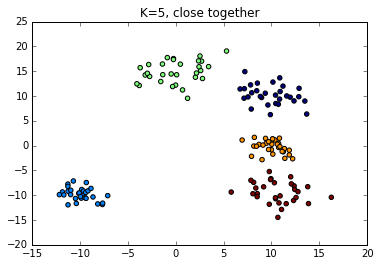

In [18]:
DB_5_c_scatter = plt.scatter(test_points_5k_c[:,0],test_points_5k_c[:,1], c = test_points_5k_c[:,2])
plt.title('K=5, close together')

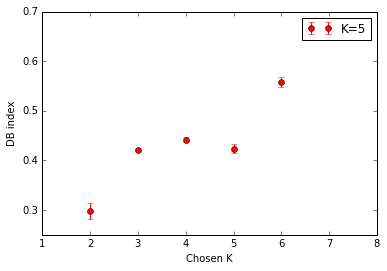

In [19]:
DB_plot_5k_c = plt.errorbar(K_list_5k_c, DB_ave_list_5k_c, yerr=DB_SDM_list_5k_c, fmt='o', color='r', label='K=5')
plt.xlim(1,8)
#plt.ylim(0.3,0.6)
plt.legend()
plt.ylabel('DB index')
plt.xlabel('Chosen K')

## For K=5, points far apart

In [8]:
# Create input clusters
centroid_list_5k_f = [np.array([10,10]), 
                    np.array([0,-5]), 
                    np.array([-20,10]), 
                    np.array([-20,-15]),
                    np.array([20,-10])]
    
cov_list_5k_f = [np.array([[5,0],[0,5]]), 
               np.array([[2,-1],[-1,2]]),
               np.array([[5,0],[0,5]]), 
               np.array([[2,-1],[-1,2]]),
               np.array([[5,0],[0,5]])]
points_split_5k_f = [30,30,30,30,30]

# for plotting clusters only
centroid_array_5k_f = np.empty([len(centroid_list_5k_f),2])
for i in range(len(centroid_list_5k_f)):
    centroid_array_5k_f[i,0] = centroid_list_5k_f[i][0]
    centroid_array_5k_f[i,1] = centroid_list_5k_f[i][1]

test_points_5k_f = k_means_datafaker(5, centroid_list_5k_f, cov_list_5k_f, points_split_5k_f)

K_list_5k_f = [] # X values
DB_ave_list_5k_f = [] # Y values
DB_SDM_list_5k_f = [] # Y error values
num_trials = 10   

for K in range(2,8,1):
    K_list_5k_f.append(K)
    DB_list = []
    for n in range(num_trials):
        points = test_points_5k_f[:,:2]
        centro, listo, mo, DBo = kmeans(points,K)
        DB_list.append(DBo)
    DB_ave = stat.mean(DB_list)
    DB_SDM = stat.stdev(DB_list) / math.sqrt(num_trials)
    DB_ave_list_5k_f.append(DB_ave)
    DB_SDM_list_5k_f.append(DB_SDM)

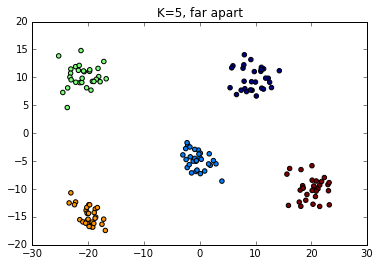

In [20]:
DB_5_f_scatter = plt.scatter(test_points_5k_f[:,0],test_points_5k_f[:,1], c = test_points_5k_f[:,2])
plt.title('K=5, far apart')

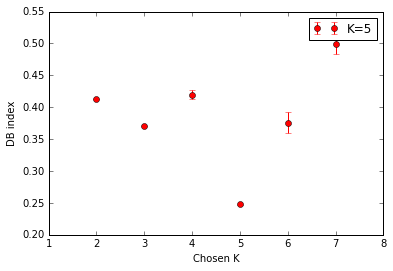

In [21]:
DB_plot_5k_f = plt.errorbar(K_list_5k_f, DB_ave_list_5k_f, yerr=DB_SDM_list_5k_f, fmt='o', color='r', label='K=5')
plt.xlim(1,8)
#plt.ylim(0.3,0.6)
plt.legend()
plt.ylabel('DB index')
plt.xlabel('Chosen K')

## For K = 3, points close together

In [11]:
# Create input clusters
centroid_list_3k_c = [np.array([0,0]), 
                    np.array([-5,-5]),
                    np.array([5,-5])]

    
cov_list_3k_c = [np.array([[5,0],[0,5]]), 
               np.array([[2,-1],[-1,2]]),
               np.array([[2,-1],[-1,2]])]
points_split_3k_c = [30,30,30]

# for plotting clusters only
centroid_array_3k_c = np.empty([len(centroid_list_3k_c),2])
for i in range(len(centroid_list_3k_c)):
    centroid_array_3k_c[i,0] = centroid_list_3k_c[i][0]
    centroid_array_3k_c[i,1] = centroid_list_3k_c[i][1]

test_points_3k_c = k_means_datafaker(3, centroid_list_3k_c, cov_list_3k_c, points_split_3k_c)

K_list_3k_c = [] # X values
DB_ave_list_3k_c = [] # Y values
DB_SDM_list_3k_c = [] # Y error values
num_trials = 10   

for K in range(2,8,1):
    K_list_3k_c.append(K)
    DB_list_c = []
    for n in range(num_trials):
        points = test_points_3k_c[:,:2]
        centro, listo, mo, DBo = kmeans(points,K)
        DB_list_c.append(DBo)
    DB_ave_c = stat.mean(DB_list_c)
    DB_SDM_c = stat.stdev(DB_list_c) / math.sqrt(num_trials)
    DB_ave_list_3k_c.append(DB_ave_c)
    DB_SDM_list_3k_c.append(DB_SDM_c)

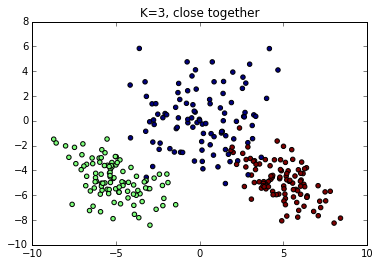

In [22]:
DB_3_c_scatter = plt.scatter(test_points_3k_c[:,0],test_points_3k_c[:,1], c = test_points_3k_c[:,2])
plt.title('K=3, close together')

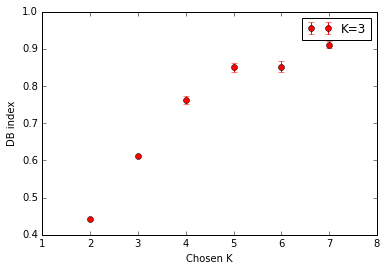

In [24]:
DB_plot_3k_c = plt.errorbar(K_list_3k_c, DB_ave_list_3k_c, yerr=DB_SDM_list_3k_c, fmt='o', color='r', label='K=3')
plt.xlim(1,8)
#plt.ylim(0.3,0.6)
plt.legend()
plt.ylabel('DB index')
plt.xlabel('Chosen K')

## For K=3, points far apart

In [15]:
# Create input clusters
centroid_list_3k_f = [np.array([10,10]), 
                    np.array([0,0]),
                    np.array([-10,-10])]

    
cov_list_3k_f = [np.array([[5,0],[0,5]]), 
               np.array([[2,-1],[-1,2]]),
               np.array([[2,-1],[-1,2]])]
points_split_3k_f = [30,30,30]

# for plotting clusters only
centroid_array_3k_f = np.empty([len(centroid_list_3k_f),2])
for i in range(len(centroid_list_3k_f)):
    centroid_array_3k_f[i,0] = centroid_list_3k_f[i][0]
    centroid_array_3k_f[i,1] = centroid_list_3k_f[i][1]

test_points_3k_f = k_means_datafaker(3, centroid_list_3k_f, cov_list_3k_f, points_split_3k_f)

K_list_3k_f = [] # X values
DB_ave_list_3k_f = [] # Y values
DB_SDM_list_3k_f = [] # Y error values
num_trials = 10   

for K in range(2,8,1):
    K_list_3k_f.append(K)
    DB_list = []
    for n in range(num_trials):
        points = test_points_3k_f[:,:2]
        centro, listo, mo, DBo = kmeans(points,K)
        DB_list.append(DBo)
    DB_ave = stat.mean(DB_list)
    DB_SDM = stat.stdev(DB_list) / math.sqrt(num_trials)
    DB_ave_list_3k_f.append(DB_ave)
    DB_SDM_list_3k_f.append(DB_SDM)

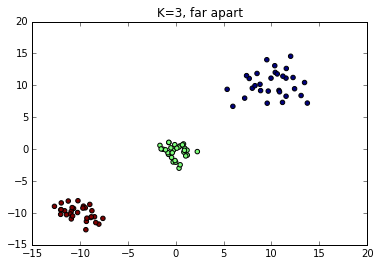

In [25]:
DB_3_f_scatter = plt.scatter(test_points_3k_f[:,0],test_points_3k_f[:,1], c = test_points_3k_f[:,2])
plt.title('K=3, far apart')

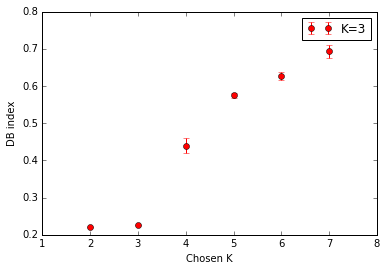

In [26]:
DB_plot_3k_f = plt.errorbar(K_list_3k_f, DB_ave_list_3k_f, yerr=DB_SDM_list_3k_f, fmt='o', color='r', label='K=3')
plt.xlim(1,8)
#plt.ylim(0.3,0.6)
plt.legend()
plt.ylabel('DB index')
plt.xlabel('Chosen K')